In [1]:
import sys,os
import numpy as np
import matplotlib.pyplot as plt

In [16]:
cd ~/Downloads/VOCdevkit/VOC2012/SegmentationClass/

/home/viha4393/Downloads/VOCdevkit/VOC2012/SegmentationClass


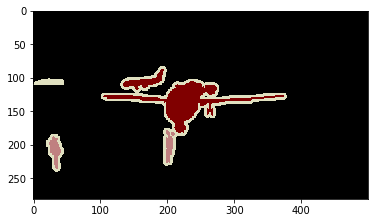

In [18]:
img = plt.imread('2007_000032.png')
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


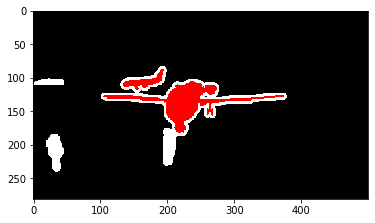

In [27]:
plt.imshow(img*255)

In [30]:
from collections import namedtuple
import numpy as np

Label = namedtuple('Label', [

    'name',
    'id',
    'color'
])

labels = [Label('background', 0, (0, 0, 0)),
          Label('aeroplane', 1, (128, 0, 0)),
          Label('bicycle', 2, (0, 128, 0)),
          Label('bird', 3, (128, 128, 0)),
          Label('boat', 4, (0, 0, 128)),
          Label('bottle', 5, (128, 0, 128)),
          Label('bus', 6, (0, 128, 128)),
          Label('car', 7, (128, 128, 128)),
          Label('cat', 8, (64, 0, 0)),
          Label('chair', 9, (192, 0, 0)),
          Label('cow', 10, (64, 128, 0)),
          Label('diningtable', 11, (192, 128, 0)),
          Label('dog', 12, (64, 0, 128)),
          Label('horse', 13, (192, 0, 128)),
          Label('motorbike', 14, (64, 128, 128)),
          Label('person', 15, (192, 128, 128)),
          Label('pottedplant', 16, (0, 64, 0)),
          Label('sheep', 17, (128, 64, 0)),
          Label('sofa', 18, (0, 192, 0)),
          Label('train', 19, (128, 192, 0)),
          Label('tvmonitor', 20, (0, 64, 128)),
          Label('void', 21, (128, 64, 12))]

voc_id2label = {label.id: label for label in labels}


def generate_color_map(N=256, normalized=False):
    """from https://gist.github.com/wllhf/a4533e0adebe57e3ed06d4b50c8419ae ."""
    def bitget(byteval, idx):
        return ((byteval & (1 << idx)) != 0)

    dtype = 'float32' if normalized else 'uint8'
    cmap = np.zeros((N, 3), dtype=dtype)
    for i in range(N):
        r = g = b = 0
        c = i
        for j in range(8):
            r = r | (bitget(c, 0) << 7 - j)
            g = g | (bitget(c, 1) << 7 - j)
            b = b | (bitget(c, 2) << 7 - j)
            c = c >> 3

        cmap[i] = np.array([r, g, b])

    cmap = cmap / 255 if normalized else cmap
    return cmap


def generate_voc_labels():
    labels = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
              'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor', 'void']
    color_map = generate_color_map()
    #plt.imshow(color_map)
    for id, name in enumerate(labels):
        color = color_map[id]
        
        print("Label(\'%s\', %i, (%i, %i, %i))," %
              (name, id, color[0], color[1], color[2]))

Label('background', 0, (0, 0, 0)),
Label('aeroplane', 1, (128, 0, 0)),
Label('bicycle', 2, (0, 128, 0)),
Label('bird', 3, (128, 128, 0)),
Label('boat', 4, (0, 0, 128)),
Label('bottle', 5, (128, 0, 128)),
Label('bus', 6, (0, 128, 128)),
Label('car', 7, (128, 128, 128)),
Label('cat', 8, (64, 0, 0)),
Label('chair', 9, (192, 0, 0)),
Label('cow', 10, (64, 128, 0)),
Label('diningtable', 11, (192, 128, 0)),
Label('dog', 12, (64, 0, 128)),
Label('horse', 13, (192, 0, 128)),
Label('motorbike', 14, (64, 128, 128)),
Label('person', 15, (192, 128, 128)),
Label('pottedplant', 16, (0, 64, 0)),
Label('sheep', 17, (128, 64, 0)),
Label('sofa', 18, (0, 192, 0)),
Label('train', 19, (128, 192, 0)),
Label('tvmonitor', 20, (0, 64, 128)),
Label('void', 21, (128, 64, 128)),


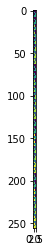

In [31]:
generate_voc_labels()